In [ ]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D
import pandas as pd
import matplotlib.pyplot as plt
import time, pickle
from keras.utils import to_categorical
from keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

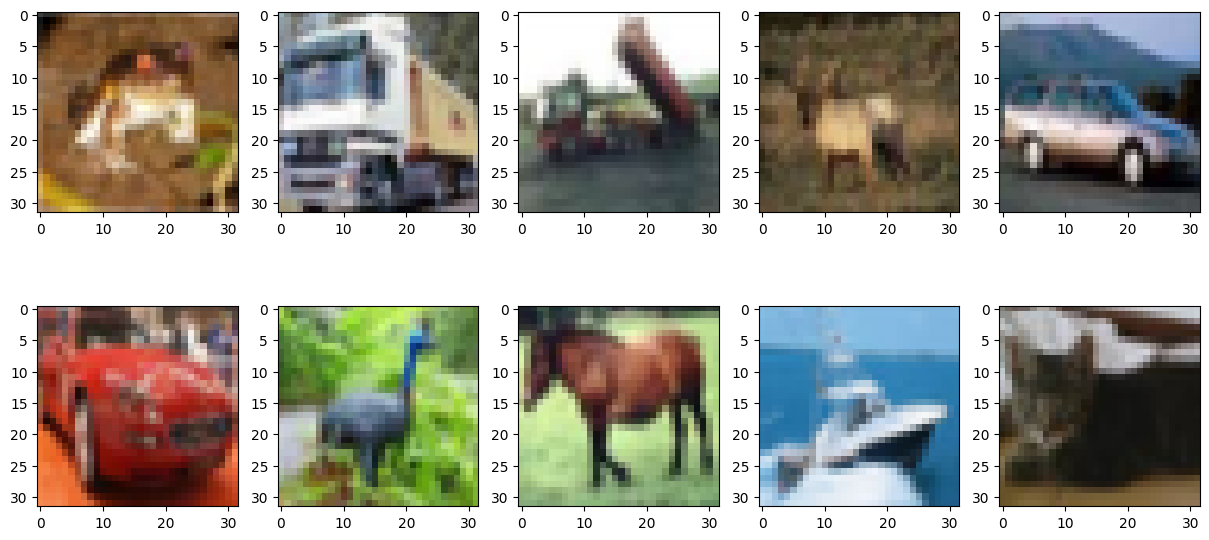

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

plt.figure(figsize=(15, 7))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(x_train[i])

In [ ]:
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'training samples')
print(x_test.shape[0], 'validation samples')

x_train shape: (50000, 32, 32, 3)
50000 training samples
10000 validation samples


In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


In [ ]:
# one-hot
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
def build_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(4,4), strides=1,activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, kernel_size=(4,4), strides=1,activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))


    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    print(model.summary())
    return model

model=build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 29, 29, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 256)               2

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

model.fit(x=x_train,y=y_train,batch_size=256,epochs=200,validation_data=(x_test,y_test),shuffle=True)
model.save("cifar10.h5")

Epoch 1/200
196/196 [==============================] - 6s 11ms/step - loss: 2.0340 - accuracy: 0.2710 - val_loss: 1.8037 - val_accuracy: 0.3653
Epoch 2/200
196/196 [==============================] - 1s 7ms/step - loss: 1.7182 - accuracy: 0.3925 - val_loss: 1.6366 - val_accuracy: 0.4229
Epoch 3/200
196/196 [==============================] - 1s 7ms/step - loss: 1.5863 - accuracy: 0.4369 - val_loss: 1.5372 - val_accuracy: 0.4564
Epoch 4/200
196/196 [==============================] - 1s 7ms/step - loss: 1.5063 - accuracy: 0.4660 - val_loss: 1.4877 - val_accuracy: 0.4710
Epoch 5/200
196/196 [==============================] - 1s 7ms/step - loss: 1.4545 - accuracy: 0.4840 - val_loss: 1.4412 - val_accuracy: 0.4867
Epoch 6/200
196/196 [==============================] - 1s 7ms/step - loss: 1.4201 - accuracy: 0.4986 - val_loss: 1.4172 - val_accuracy: 0.4996
Epoch 7/200
196/196 [==============================] - 1s 8ms/step - loss: 1.3881 - accuracy: 0.5104 - val_loss: 1.3797 - val_accuracy: 0.512

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("cifar10.tflite", "wb").write(tflite_model)

905868

In [ ]:
!apt-get -qq install xxd
!xxd -i cifar10.tflite > cifar10.cc

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
1/1 [==============================] - 0s 19ms/step
[[1.0309424e-02 2.0606534e-01 7.6583701e-01 7.4388325e-04 7.1976669e-03
  3.4208922e-04 2.5875079e-03 6.3055358e-03 3.8380138e-04 2.2782155e-04]]
[2]
C代码文件已生成：image_array.h


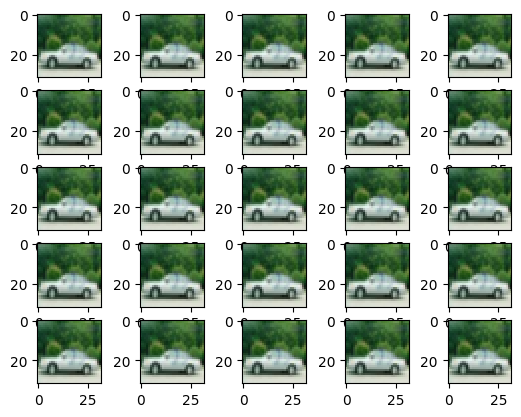

In [41]:
#预测
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

import numpy as np
x = x_test[330]
y = y_test[330]
print(y)

#多打印，不然太糊了
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(x)
x = np.expand_dims(x, axis=0)

result = model.predict(x)
print(result)
print(np.argmax(result,1))

#转出为数组

x_array = np.array(x)
x_array_flatten = x_array.flatten()
c_array_string = "{" + ", ".join(str(pixel) for pixel in x_array_flatten) + "}"

with open("image_array.h", "w") as f:
    f.write("#ifndef IMAGE_ARRAY_H\n")
    f.write("#define IMAGE_ARRAY_H\n\n")
    f.write("const float image_array[] = %s;\n" % c_array_string)
    f.write("#endif\n")

print("C代码文件已生成：image_array.h")
